In [22]:
import torch
from torch import nn
from d2l import torch as d2l
import hues
from prettytable import PrettyTable

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

In [38]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten()
)

In [20]:
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((5, 7))
# input = torch.ones(1, 1, 9, 9)
input = torch.arange(0, 49, 1, dtype=torch.float32).reshape(-1, 7, 7)
input

tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
         [ 7.,  8.,  9., 10., 11., 12., 13.],
         [14., 15., 16., 17., 18., 19., 20.],
         [21., 22., 23., 24., 25., 26., 27.],
         [28., 29., 30., 31., 32., 33., 34.],
         [35., 36., 37., 38., 39., 40., 41.],
         [42., 43., 44., 45., 46., 47., 48.]]])

In [21]:
m(input)

tensor([[[ 3.5000,  4.5000,  5.5000,  6.5000,  7.5000,  8.5000,  9.5000],
         [10.5000, 11.5000, 12.5000, 13.5000, 14.5000, 15.5000, 16.5000],
         [21.0000, 22.0000, 23.0000, 24.0000, 25.0000, 26.0000, 27.0000],
         [31.5000, 32.5000, 33.5000, 34.5000, 35.5000, 36.5000, 37.5000],
         [38.5000, 39.5000, 40.5000, 41.5000, 42.5000, 43.5000, 44.5000]]])

In [41]:
X = torch.rand(size=(1, 1, 224, 224))

tb = PrettyTable(['Index', 'Layer', 'Input Shape', 'Output Shape'])
for i, layer in enumerate(net):
    if isinstance(layer, nn.Sequential):
        for j, in_layer in enumerate(layer):
            input_shape = X.shape
            X = in_layer(X)
            output_shape = X.shape
            tb.add_row([f'{i}-{j}', in_layer.__class__.__name__, list(input_shape), list(output_shape)])
    else:
        input_shape = X.shape
        X = layer(X)
        output_shape = X.shape
        tb.add_row([f'{i}', layer.__class__.__name__, list(input_shape), list(output_shape)])

print(tb)

+-------+-------------------+------------------+------------------+
| Index |       Layer       |   Input Shape    |   Output Shape   |
+-------+-------------------+------------------+------------------+
|  0-0  |       Conv2d      | [1, 1, 224, 224] | [1, 96, 54, 54]  |
|  0-1  |        ReLU       | [1, 96, 54, 54]  | [1, 96, 54, 54]  |
|  0-2  |       Conv2d      | [1, 96, 54, 54]  | [1, 96, 54, 54]  |
|  0-3  |        ReLU       | [1, 96, 54, 54]  | [1, 96, 54, 54]  |
|  0-4  |       Conv2d      | [1, 96, 54, 54]  | [1, 96, 54, 54]  |
|  0-5  |        ReLU       | [1, 96, 54, 54]  | [1, 96, 54, 54]  |
|   1   |     MaxPool2d     | [1, 96, 54, 54]  | [1, 96, 26, 26]  |
|  2-0  |       Conv2d      | [1, 96, 26, 26]  | [1, 256, 26, 26] |
|  2-1  |        ReLU       | [1, 256, 26, 26] | [1, 256, 26, 26] |
|  2-2  |       Conv2d      | [1, 256, 26, 26] | [1, 256, 26, 26] |
|  2-3  |        ReLU       | [1, 256, 26, 26] | [1, 256, 26, 26] |
|  2-4  |       Conv2d      | [1, 256, 26, 26] |

loss 0.335, train acc 0.874, test acc 0.880
1294.2 examples/sec on cuda


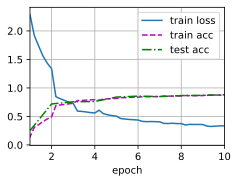

In [32]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# Finding device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)